In [1]:
#3(b) Download the Old Faithful Geyser Dataset. 
#The data file contains 272 observations of (eruption time, waiting time)
#Treat each entry as a 2 dimensional feature vector. 
#Parse and plot all data points on 2-D plane.

import numpy as np

#load data using loadtxt in numpy
data = np.loadtxt('faithful.dat.txt', skiprows=26, usecols=(1,2))
data_size = len(data)
eruptions = data[:,0] #data[row:col]; selected for the first col in data - eruptions data set
waiting = data[:,1] #data[row:col]; selected for the second col in data - waiting data set

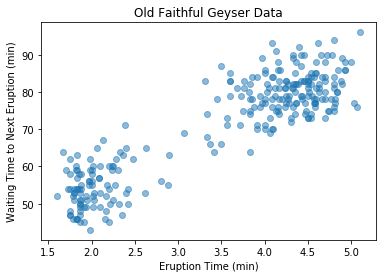

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#display data using pyplot
plt.scatter(eruptions, waiting, alpha=0.5) #parameters = (x,y,transparency)
plt.title('Old Faithful Geyser Data')
plt.xlabel('Eruption Time (min)')
plt.ylabel('Waiting Time to Next Eruption (min)')
plt.show()

In [3]:
#(c) Implement a bimodal GMM model to fit all data points using EM algorithm. 
#Explain the reasoning behind your termination criteria. For this problem, we assume the 
#covariance matrix is spherical (i.e., it has the form of σ2 I for scalar σ) and you can 
#randomly initialize Gaussian parameters. For evaluation purposes, please submit the following 
#figures:
# - Plot the trajectories of two mean vectors in 2 dimensions (i.e.,coordinates vs. iteration).
# - Run your program for 50 times with different initial parameter guesses. 
#Show the distribution of the total number of iterations needed for algorithm to converge.
#Source: https://github.com/stober/gmm/tree/master/src
#Source: https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb
#Source: https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian.py

from scipy import stats

#Initialize parameters μ(mean), Σ(variance), π(prior probability)
def random_Mu_Sigma_Pi(data): 
    dim =2 #dimensions
    
    #randomize mean
    mu = np.zeros(dim) 
    for i in range(dim):
        mu[i]=np.min(data[:,i])+np.max(data[:,i])*np.random.rand()*0.5 
    
    #randomize sigma
    sigma = np.asarray([[np.random.rand(),0],[0,np.random.rand()]])
    
    #randomize pi: assumes priors are not uniform, should add up to 1 
    pi = np.ones(2)
    pi[0] = np.random.rand()
    pi[1] = 1 - pi[0]
    
    return [mu, sigma, pi]

In [4]:
from sklearn.cluster import KMeans

def initial_Norm_Dist(data, GMM=True):
    #Obtain random Gaussian variables (mean, variance, prior) from first and second halves of the data
    #if GMM is true, proceed to GMM case
    if GMM :
        mean1, sigma1, pi = random_Mu_Sigma_Pi(data[0:136]) 
        mean2, sigma2, pi2 = random_Mu_Sigma_Pi(data[136:])
    
    #if GMM is false, proceed to KMeans
    else:
        #initializing pi
        pi = np.ones(2)
        pi[0] = np.random.rand()
        pi[1] = 1 - pi[0]
        
        #initializing KMeans model
        k = 2
        model = KMeans(n_clusters=k)
        model.fit(data) 
        labels = model.labels_ #array specifying the label of the owning cluster for each article in data
        
        #get the indices that were labeled 0 for cluster 1
        cluster1 = data[np.where(labels==0)]
        sigma1 = np.cov(cluster1.T)
        mean1 = cluster1.mean(axis=0) 
        
        #get the indices that were labeled 0 for cluster 2
        cluster2 = data[np.where(labels==1)]
        sigma2 = np.cov(cluster2.T)
        mean2 = cluster2.mean(axis=0) 

    return mean1, sigma1, mean2, sigma2, pi

In [5]:
def E_step(data, mean1, sigma1, mean2, sigma2, pi):
    
    resp = np.zeros(data_size)
        
    #calculate responsibilties
    mvnorm_dist1 = stats.multivariate_normal(mean1, sigma1)
    mvnorm_dist2 = stats.multivariate_normal(mean2, sigma2)

    for i in range(data_size):
        resp_1 = pi[0] * mvnorm_dist2.pdf(data[i]) 
        resp_2 = pi[1] * mvnorm_dist1.pdf(data[i]) 
        resp[i]=(resp_1/(resp_1 + resp_2)) #normalize the weights
        if np.isnan(resp[i]):
            resp[i]=0.0
            
    return resp, pi, mvnorm_dist1, mvnorm_dist2

In [6]:
def M_step(data, centroid1, centroid2, resp, pi, mean1, sigma1, mean2, sigma2):
    #calculate new means with changed responsibilities
    new_mean1 = np.dot((1-resp), data)/(np.sum(1-resp))
    new_mean2 = np.dot((resp), data)/(np.sum(resp))
    
    def calculate_variance(new_mean, first_variance=True):
        new_variance = np.zeros((2,2))
        for i in range(data_size):
            if first_variance:
                x, y = 1 - resp[i], 1 - resp 
            else:
                x, y = resp[i], resp
            new_variance += (x) * (np.outer(data[i] - new_mean, data[i] - new_mean))
        new_variance = new_variance / np.sum(y)
        return new_variance
    
    #calculate new variances with changed responsibilities, means
    new_variance1 = calculate_variance(new_mean1)
    new_variance2 = calculate_variance(new_mean2, first_variance=False)

    #calculate new priors with changed responsibilities
    pi = [resp.mean(axis=0), resp.mean(axis=0)]
    
    #save new mean and variance, to use again in E-step
    mean1, sigma1 = new_mean1, new_variance1
    mean2, sigma2 = new_mean2, new_variance2
    
    centroid1.append(mean1)
    centroid2.append(mean2)
    
    return centroid1, centroid2, pi, mean1, sigma1, mean2, sigma2

In [7]:
def EM_algo(data, mean1, sigma1, mean2, sigma2, pi, iterations = 100):
    
    centroid1=[mean1]
    centroid2=[mean2]
        
    old_likelihood = 0
    for i in range(iterations):
        new_likelihood = 0 #reinitialize new_likelihood as 0 for every iteration
        
        #E-Step
        resp, pi, mvnorm_dist1, mvnorm_dist2 = E_step(data, mean1, sigma1, mean2, sigma2, pi)
        #M-Step
        centroid1, centroid2, pi, mean1, sigma1, mean2, sigma2 = M_step(data, centroid1, centroid2, resp, pi, mean1, sigma1, mean2, sigma2)
        
        #Likelihood calculations: dependent on the responsibilities and Multivariate Normal PDF calculated in E-Step
        for j in range(data_size):
            new_likelihood += (1 - resp[j]) * np.log(mvnorm_dist1.pdf(data[j])) + resp[j] * np.log(mvnorm_dist2.pdf(data[j]))
    
        #Termination: compare likelihoods to see if they converged at a threshold below 0.01
        if np.abs(new_likelihood-old_likelihood) < 0.01:
            return i, np.asarray(centroid1), np.asarray(centroid2)
        else:
            old_likelihood = new_likelihood
            
    #reach this line if likelihood never converged, ran through 100 iterations
    return iterations, np.asarray(centroid1), np.asarray(centroid2)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Num of iterations: 19


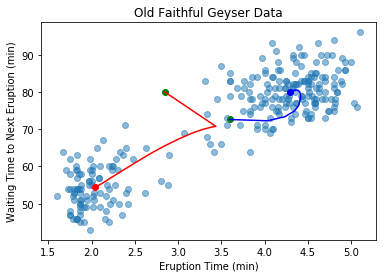

0 : 7
1 : 7
2 : 8
3 : 16
4 : 6
5 : 9
6 : 11
7 : 5
8 : 12
9 : 8
10 : 10
11 : 27
12 : 25
13 : 18
14 : 8
15 : 9
16 : 7
17 : 14
18 : 6
19 : 18
20 : 28
21 : 18
22 : 20
23 : 11
24 : 9
25 : 7
26 : 10
27 : 8
28 : 6
29 : 5
30 : 14
31 : 7
32 : 19
33 : 7
34 : 12
35 : 6
36 : 5
37 : 7
38 : 14
39 : 8
40 : 8
41 : 18
42 : 6
43 : 8
44 : 16
45 : 13
46 : 8
47 : 14
48 : 7
49 : 7


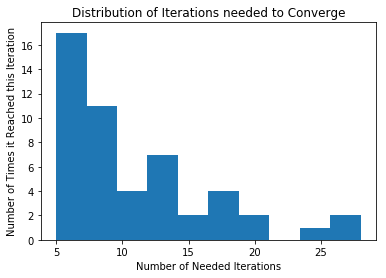

In [8]:
#(c) GMM initialization

mean1, sigma1, mean2, sigma2, pi = initial_Norm_Dist(data, GMM=True)
iterations, cluster1, cluster2 = EM_algo(data, mean1, sigma1, mean2, sigma2, pi) 
print("Num of iterations:",iterations)

#Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration).
plt.scatter(eruptions, waiting, alpha=0.5) 
plt.plot(cluster1[:,0], cluster1[:,1], color='red') 
plt.scatter(cluster1[0,0], cluster1[0,1], color='green') 
plt.scatter(cluster1[-1][0], cluster1[-1][1], color='red')
plt.plot(cluster2[:,0], cluster2[:,1], color='blue')
plt.scatter(cluster2[0,0], cluster2[0,1], color='green')
plt.scatter(cluster2[-1][0], cluster2[-1][1], color='blue')
plt.title('Old Faithful Geyser Data')
plt.xlabel('Eruption Time (min)')
plt.ylabel('Waiting Time to Next Eruption (min)')
plt.show()

#Run your program for 50 times with different initial parameter guesses.
Total_Iterations = []
for i in range(50):
    #run gmm using em algorithm
    mean1, sigma1, mean2, sigma2, pi = initial_Norm_Dist(data, GMM=True)
    iterations, cen1, cen2 = EM_algo(data, mean1, sigma1, mean2, sigma2, pi) 
    Total_Iterations.append(iterations)
    print (i,":",iterations) 

#Show the distribution of the total number of iterations needed for algorithm to converge.
freq = np.asarray(Total_Iterations)
plt.hist(freq)
plt.xlabel('Number of Needed Iterations')
plt.ylabel('Number of Times it Reached this Iteration')
plt.title('Distribution of Iterations needed to Converge')

Num of iterations: 4


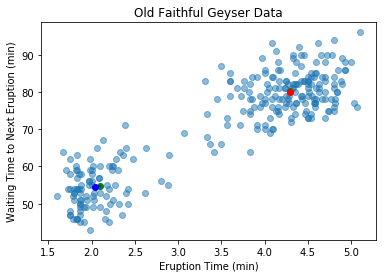

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0 : 12


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


1 : 14
2 : 9
3 : 13
4 : 8
5 : 7
6 : 8
7 : 10
8 : 20
9 : 10
10 : 8
11 : 18
12 : 13
13 : 6
14 : 11
15 : 5
16 : 10
17 : 14
18 : 5
19 : 8
20 : 13
21 : 18
22 : 6
23 : 4
24 : 7
25 : 19
26 : 26
27 : 10
28 : 7
29 : 9
30 : 34
31 : 14
32 : 9
33 : 13
34 : 27
35 : 13
36 : 31
37 : 8
38 : 5
39 : 15
40 : 6
41 : 4
42 : 8
43 : 6
44 : 9
45 : 14
46 : 13
47 : 5
48 : 24
49 : 6


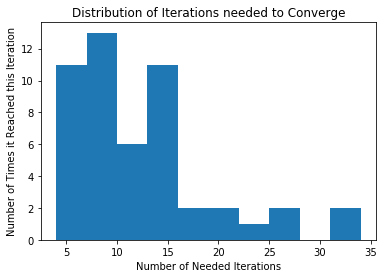

In [13]:
#(d) KMeans initialization

mean1, sigma1, mean2, sigma2, pi = initial_Norm_Dist(data, GMM=False)
iterations, cluster1, cluster2 = EM_algo(data, mean1, sigma1, mean2, sigma2, pi) 
print("Num of iterations:",iterations)

#Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration).
plt.scatter(eruptions, waiting, alpha=0.5) 
plt.plot(cluster1[:,0], cluster1[:,1], color='red') 
plt.scatter(cluster1[0,0], cluster1[0,1], color='green') 
plt.scatter(cluster1[-1][0], cluster1[-1][1], color='red')
plt.plot(cluster2[:,0], cluster2[:,1], color='blue')
plt.scatter(cluster2[0,0], cluster2[0,1], color='green')
plt.scatter(cluster2[-1][0], cluster2[-1][1], color='blue')
plt.title('Old Faithful Geyser Data')
plt.xlabel('Eruption Time (min)')
plt.ylabel('Waiting Time to Next Eruption (min)')
plt.show()

#Run your program for 50 times with different initial parameter guesses.
Total_Iterations = []
for i in range(50):
    #run gmm using em algorithm
    mean1, sigma1, mean2, sigma2, pi = initial_Norm_Dist(data, GMM=True)
    iterations, cen1, cen2 = EM_algo(data, mean1, sigma1, mean2, sigma2, pi) 
    Total_Iterations.append(iterations)
    print (i,":",iterations) 

#Show the distribution of the total number of iterations needed for algorithm to converge.
freq = np.asarray(Total_Iterations)
plt.hist(freq)
plt.xlabel('Number of Needed Iterations')
plt.ylabel('Number of Times it Reached this Iteration')
plt.title('Distribution of Iterations needed to Converge')